In [1]:
import numpy as np
import scipy.io as spio

In [2]:
file = r'C:\Users\spenc\Desktop\Experiments\ftp_files\cyst_phantom\pht_data.mat'
mat = spio.loadmat (file)
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Jul 11 19:52:02 2018',
 '__version__': '1.0',
 '__globals__': [],
 'phantom_positions': array([[ 0.01573618, -0.00222605,  0.059822  ],
        [ 0.0202896 ,  0.00122839,  0.05560369],
        [-0.01865066, -0.00046351,  0.04396769],
        ...,
        [-0.015     ,  0.        ,  0.07      ],
        [-0.015     ,  0.        ,  0.08      ],
        [-0.015     ,  0.        ,  0.09      ]]),
 'phantom_amplitudes': array([[ 1.6769148 ],
        [ 1.42544227],
        [ 0.07946215],
        ...,
        [20.        ],
        [20.        ],
        [20.        ]])}

In [3]:
pos, amp = mat['phantom_positions'], mat['phantom_amplitudes']
pos.shape, amp.shape

((100000, 3), (100000, 1))

In [4]:
scatterers = np.concatenate ([pos, amp], axis=-1)
scatterers.shape, scatterers.dtype

((100000, 4), dtype('<f8'))

In [5]:
from pyrfsim import RfSimulator

# Create and configure GPU simulator
device = 'gpu'
sim = RfSimulator (device)
sim.set_parameter ('verbose', '1')
sim.set_print_debug (True)

In [6]:
from itertools import chain, groupby

print (*dir (sim), sep='\n')

__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__gt__
__hash__
__init__
__init_subclass__
__instance_size__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__sizeof__
__str__
__subclasshook__
__weakref__
add_fixed_scatterers
add_spline_scatterers
clear_fixed_scatterers
clear_spline_scatterers
get_debug_data
get_parameter
get_total_num_scatterers
set_analytical_beam_profile
set_excitation
set_lut_beam_profile
set_parameter
set_print_debug
set_scan_sequence
simulate_lines


In [7]:
# Set general simulation parameters
sim.set_parameter ('sound_speed', '1540.0')
sim.set_parameter ('radial_decimation', '20') # i.e. scan-direction downsampling factor
sim.set_parameter ('phase_delay', 'on')

In [8]:
# Set scatterers
use_demo1_data = use_cyst_phantom = False
use_demo1_data = not use_cyst_phantom
use_cyst_phantom = not use_demo1_data

sim.clear_fixed_scatterers () # Make this cell idempotent

if use_demo1_data:
    num_scatterers = 16
    scatterers_data = np.zeros ((num_scatterers, 4), dtype='float32')
    scatterers_data[:,0] = np.linspace (-.02, 0.02, num_scatterers)
#     scatterers_data[:,2] = np.linspace (0.01, 0.16, num_scatterers)
    scatterers_data[:,2] = np.linspace (0.01, 0.19, num_scatterers)
    scatterers_data[:,3] = np.ones ((num_scatterers,))
    # scatterers_data[:,3] = np.arange (1, num_scatterers + 1)
elif use_cyst_phantom:
    scatterers_data = scatterers.astype ('float32')

sim.add_fixed_scatterers (scatterers_data)

In [ ]:
from scipy.signal import gausspulse
import matplotlib.pyplot as plt

# Define excitation signal
fs = 50e6
ts = 1.0/fs
fc = 2.5e6
tc = 1.0/fc
t_vector = np.arange (-16*tc, 16*tc, ts)
bw = 0.5
samples = gausspulse (t_vector, bw=bw, fc=fc).astype ('float32')
center_index = len (t_vector) // 2
sim.set_excitation (samples, center_index, fs, fc)

# Plot excitation signal
plt.plot (t_vector, samples);
plt.title ('Excitation signal')
plt.xlabel ('Time [s]')
plt.ylabel ('Exitation')
plt.show ()

In [110]:
# Define a scan sequence
num_lines = 200
origins = np.zeros ((num_lines, 3), dtype='float32')
origins[:,0] = np.linspace (-0.04, 0.04, num_lines)

x_axis = np.array ([1.0, 0.0, 0.0])
y_axis = np.array ([0.0, 1.0, 0.0])
z_axis = np.array ([0.0, 0.0, 1.0])

directions = np.tile (z_axis, (num_lines, 1)).astype ('float32')
lateral_dirs = np.tile (x_axis, (num_lines, 1)).astype ('float32')
timestamps = np.zeros ((num_lines,), dtype='float32')
line_length = .20
sim.set_scan_sequence (origins, directions, line_length, lateral_dirs, timestamps)

In [21]:
# Set the beam profile
sigma_lateral = 1e-3
sigma_elevational = 1e-3
sim.set_analytical_beam_profile (sigma_lateral, sigma_elevational)

In [114]:
# Do the simulation : result is IQ data
iq_lines = sim.simulate_lines ()

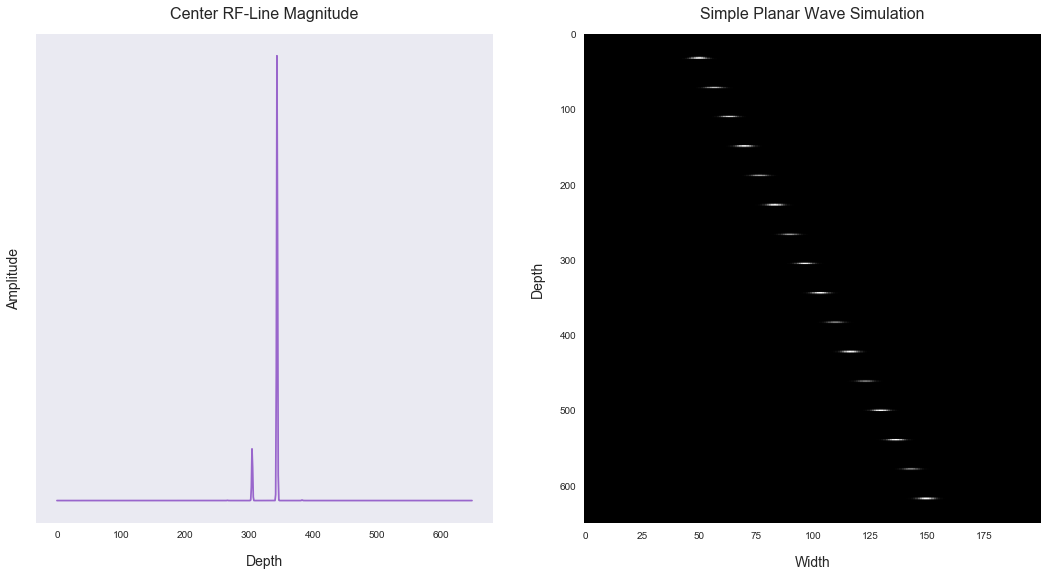

In [115]:
# Visualize results
import sys
sys.path.append ('..')
from visualize import *

title = 'Simple Planar Wave Simulation'
visualize (iq_lines, title, figsize=(18, 9))